In [352]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from textwrap import wrap

import sklearn
from sklearn.linear_model import LinearRegression

## Notebook Parameters

In [353]:
target_coc = "example_coc.xlsm"
write_to_master = False
master_data = "example_data.xlsx"
use_sample_date = False # otherwise will use most recent sampling from master_data

### Functions

In [354]:
# Cleaning Functions

def clean_nan(x):
    if x == '':
        return np.nan
    else:
        return x

def clean_text_columns(x):
    if x[-1] == ' ':
        return x[:-1]
    else:
        return x

# Analysis Functions
def create_sample_name(df_):
    sample_name_list = []
    for i in range(df_.index[-1]+1):
        sample_name_list.append(str(df_.iloc[i][:]['Source']) + ' '
                                + str(df_.iloc[i][:]['Area']) + ' '
                                + str(int(df_.iloc[i][:]['Floor'])) + ' '
                                + str(df_.iloc[i][:]['Type']) + ' '
                                + str(df_.iloc[i][:]['Location']))

    sample_name_series = pd.Series(sample_name_list,name='full_sample_name')

    df_['full_sample_name'] = sample_name_series
    return df_

# Read/Write Functions

def write_excel(filename,sheetname,dataframe):
    with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer: 
        workBook = writer.book
        try:
            workBook.remove(workBook[sheetname])
        except:
            print("Worksheet does not exist")
        finally:
            dataframe.to_excel(writer, sheet_name=sheetname,index=False)
            writer.save()



## Import and Clean

In [355]:
# Import and Clean

df = pd.read_excel(target_coc,header=13)
df = df.filter(df.columns[2:-1]).copy(deep=True)
hist_df = pd.read_excel(master_data)

hist_df['Date'] = pd.to_datetime(hist_df['Date']).dt.date

df['Legionella'] = np.full((df.index[-1]+1,1),np.nan)
df['Lp_Positive'] = np.full((df.index[-1]+1,1),np.nan)

df.columns = ['Date','Time','Source','Area','Floor',
              'Type','Location','Taken_By','Temp',
              'FRO','TRO','Avery','Legionella','Lp_Positive']

df['Date'] = pd.to_datetime(df['Date']).dt.date

df = df.filter(['Date','Time','Source','Area','Floor',
              'Type','Location','Taken_By','Temp',
              'FRO','TRO','Legionella','Lp_Positive','Avery',]).copy(deep=True)

df['TRO'] = df['TRO'].map(clean_nan)

count = 0
for cell in df.Taken_By:
    if type(cell) != str:
        break
    count += 1

df = df.iloc[:][:count].copy(deep=True)

text_columns = ['Source']

for column in text_columns:
    df[column] = df[column].map(clean_text_columns)

five_recent_sampling_events = [str(x) for x in list(hist_df.groupby('Date').mean().reset_index().Date.sort_values().head())]

## Data Preparation

## Exporting Data

In [356]:
# Export COC to Master Excel File

if write_to_master:
    combo_df = pd.concat([hist_df,df])
    combo_df.reset_index(inplace=True,drop=True)

    write_excel(master_data,'Analytical_Data',combo_df)

In [357]:
# Adding Analysis Columns

df = create_sample_name(df).copy(deep=True)
hist_df = create_sample_name(hist_df).copy(deep=True)

## Plotting Leading Indicators

In [358]:
if use_sample_date:
    while True:
        try:
            sample_date = f'{input(five_recent_sampling_events)}'
            if sample_date in five_recent_sampling_events:
                break
        except:
            print("Invalid Input")

    dataframe_to_use = hist_df[hist_df['Date'] == sample_date]

else:
    dataframe_to_use = hist_df[hist_df['Date']== hist_df['Date'].max()]
    sample_date = hist_df['Date'].max()

# Plot Setup

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "calibri"

### Temperature Plotting

#### By Source

In [359]:
# Group by Source

source_dict = {}
uniques = list(dataframe_to_use.Source.value_counts().index)
for unique_group in uniques:
    source_dict[f'{unique_group}'] = dataframe_to_use[dataframe_to_use['Source'] == unique_group]

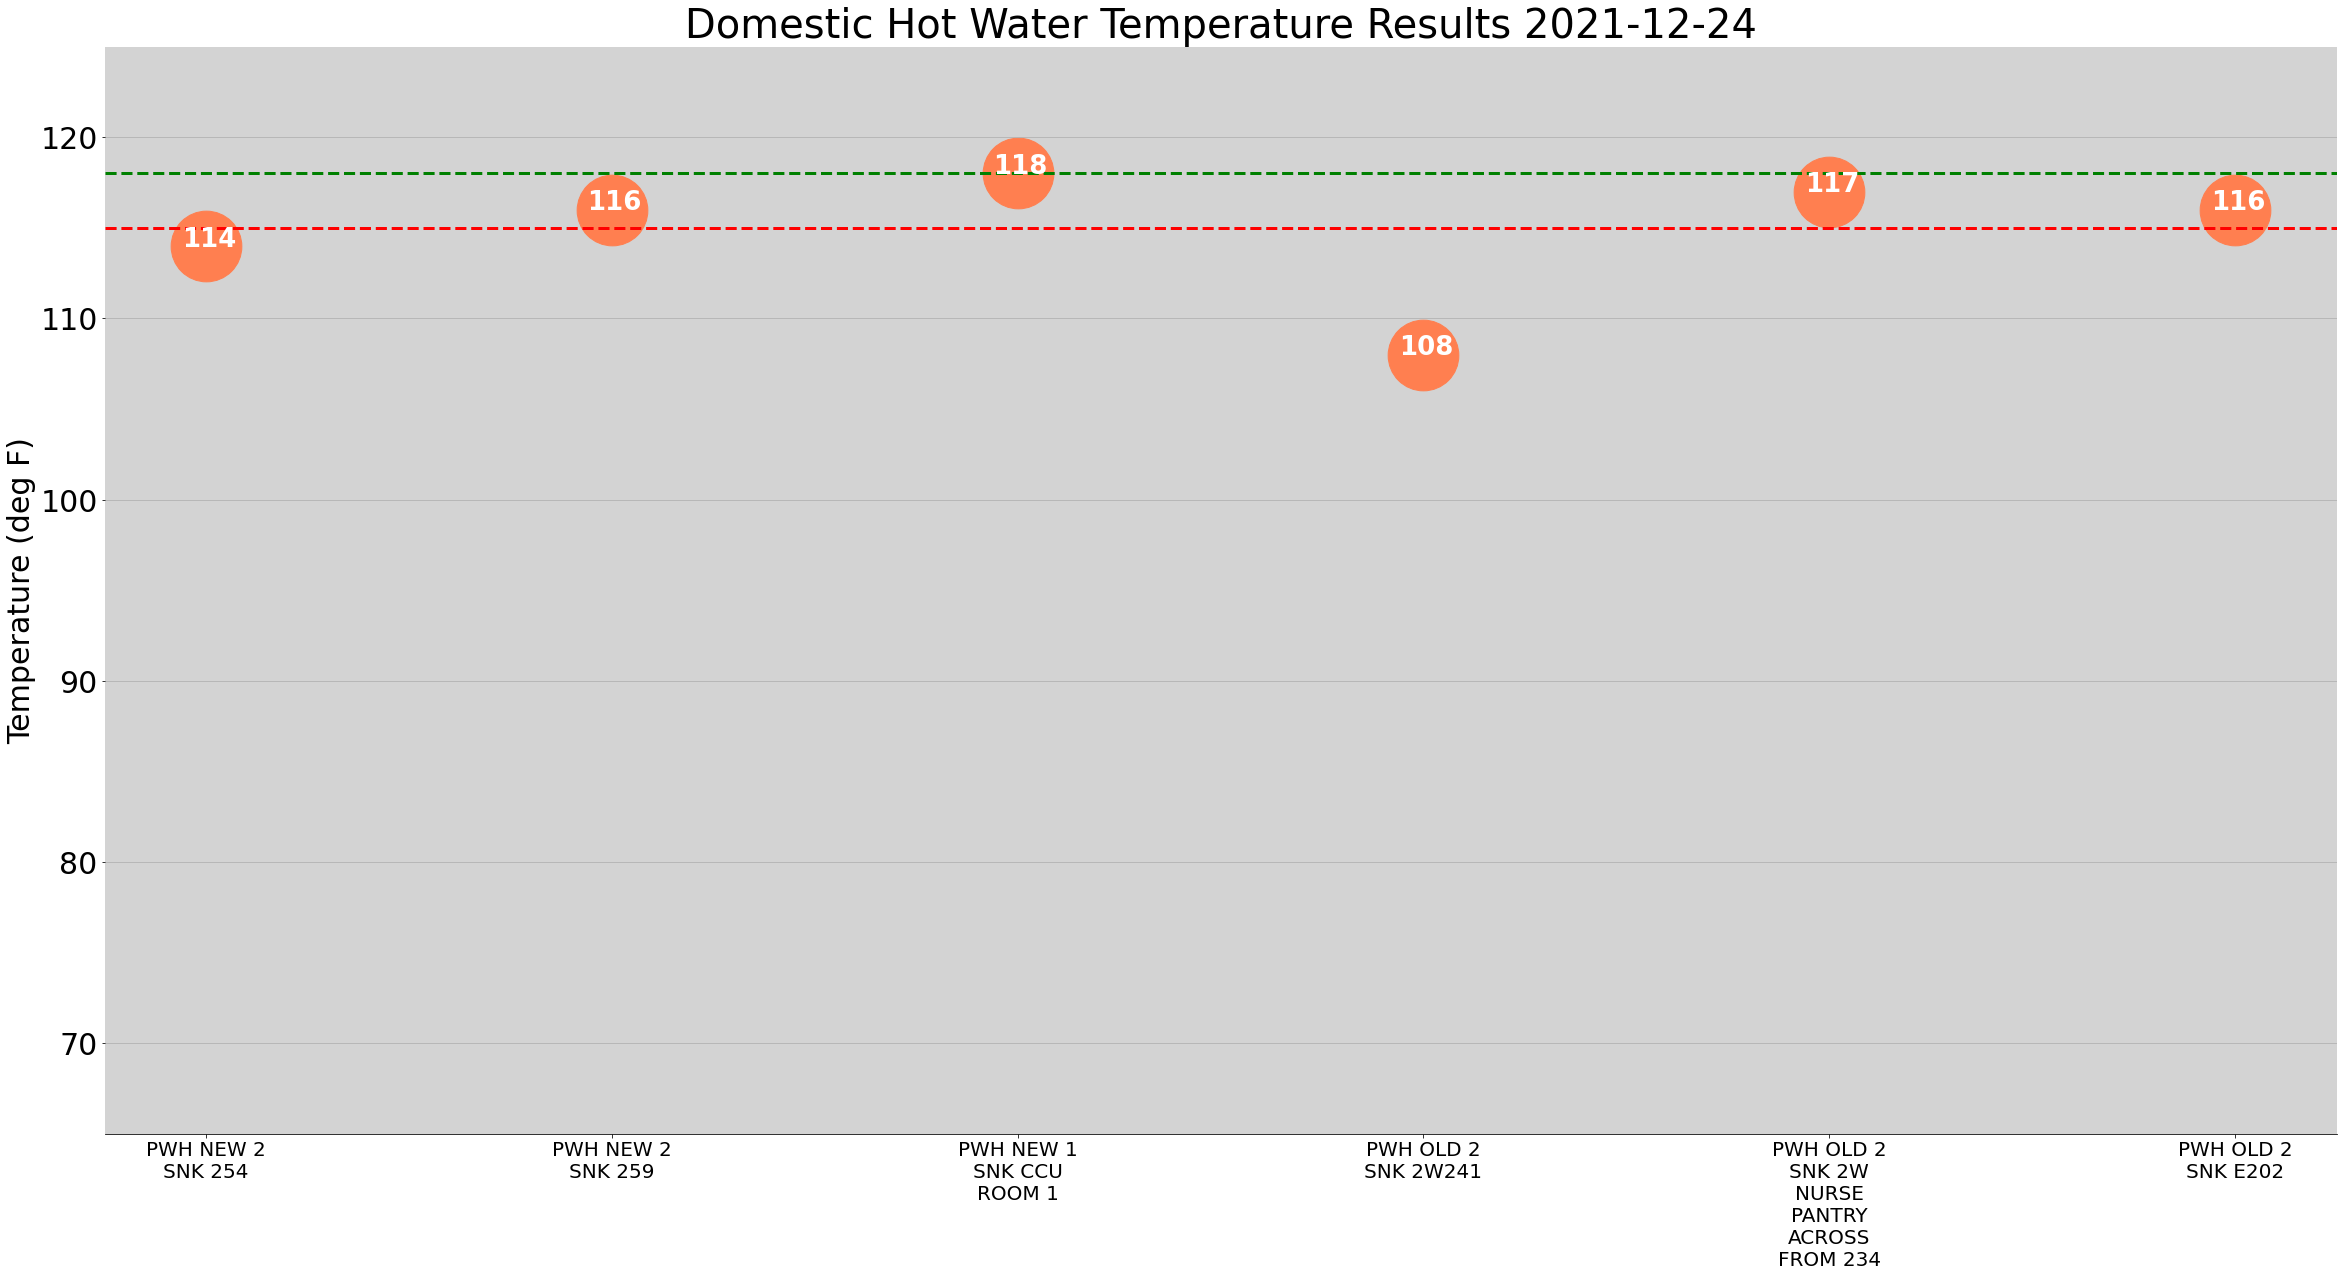

In [360]:
# Hot Temperature Graph Generator

dataframe_to_use_1 = source_dict['PWH']
figure_size = (40,20)
y_min = 65
y_max = 125
y_high_risk = 115
y_low_risk = 118

lp_df_1 = dataframe_to_use_1[dataframe_to_use_1['Lp_Positive'] == 'YES']

###################

fig,ax = plt.subplots(1,1,figsize=figure_size)

xlabels = ['\n'.join(wrap(l, 10)) for l in list(dataframe_to_use_1.full_sample_name)]
xlabels_lp = ['\n'.join(wrap(l, 10)) for l in list(lp_df_1.full_sample_name)]

ax.scatter(xlabels,dataframe_to_use_1['Temp'],s=5000,color='coral')
ax.scatter(xlabels_lp,lp_df_1['Temp'],s=5000,facecolors='None', edgecolor='red',linewidths=10)
ax.set_ylim((y_min,y_max))
ax.set_ylabel('Temperature (deg F)')
ax.set_title(f'Domestic Hot Water Temperature Results {sample_date}')
ax.axhline(y=y_high_risk,color='r',linestyle='--',linewidth=3)
ax.axhline(y=y_low_risk,color='green',linestyle='--',linewidth=3)
ax.set_facecolor('lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y')


plot_text = list(dataframe_to_use_1.Temp)
plot_text = [str(x)[:-2] for x in plot_text]

spacing_dict = {1:0, 2:-0.01, 3:-0.02, 6: -0.06}

spacing = list(np.arange(start=spacing_dict[len(dataframe_to_use_1.index)],
                         stop=len(dataframe_to_use_1.index),
                         step=1))

for i, txt in enumerate(plot_text):
    ax.annotate(txt, (spacing[i],list(dataframe_to_use_1['Temp'])[i]),
                size=26,color='white',weight='bold')

plt.savefig('images/DHW_temp.png')

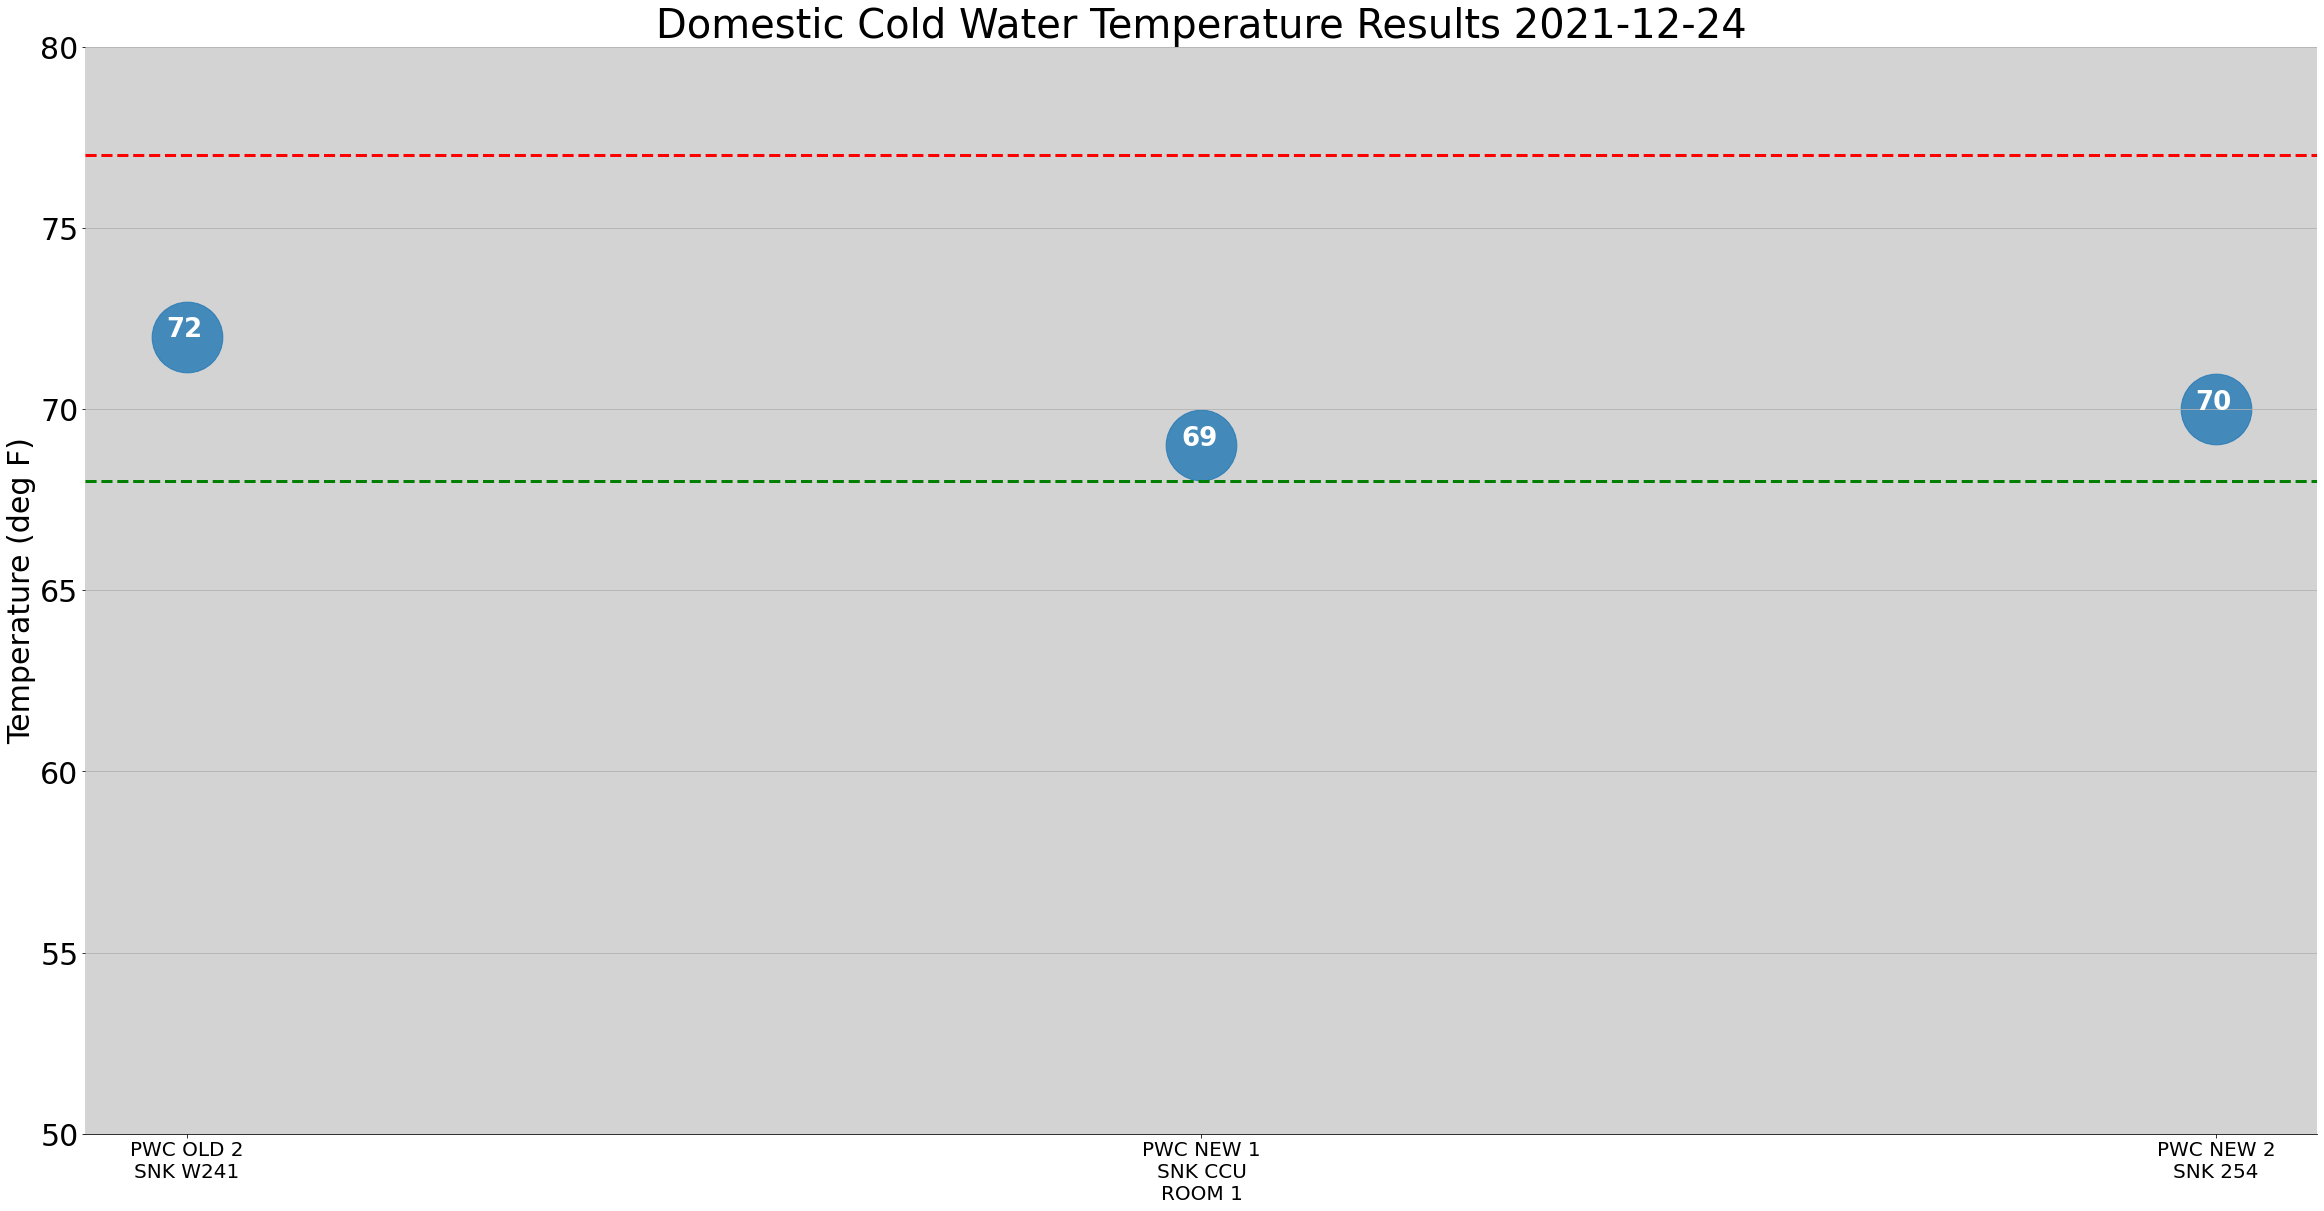

In [361]:
# Cold Temperature Graph Generator

dataframe_to_use_1 = source_dict['PWC']
figure_size = (40,20)
y_min = 50
y_max = 80
y_high_risk = 77
y_low_risk = 68

lp_df_1 = dataframe_to_use_1[dataframe_to_use_1['Lp_Positive'] == 'YES']

###################

fig,ax = plt.subplots(1,1,figsize=figure_size)

xlabels = ['\n'.join(wrap(l, 10)) for l in list(dataframe_to_use_1.full_sample_name)]
xlabels_lp = ['\n'.join(wrap(l, 10)) for l in list(lp_df_1.full_sample_name)]

ax.scatter(xlabels,dataframe_to_use_1['Temp'],s=5000,alpha=0.8)
ax.scatter(xlabels_lp,lp_df_1['Temp'],s=5000,facecolors='None', edgecolor='red',linewidths=10)

ax.set_ylabel('Temperature (deg F)')
ax.set_title(f'Domestic Cold Water Temperature Results {sample_date}')
ax.set_ylim((y_min,y_max))
ax.axhline(y=y_high_risk,color='r',linestyle='--',linewidth=3)
ax.axhline(y=y_low_risk,color='green',linestyle='--',linewidth=3)
ax.set_facecolor('lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y')

plot_text = list(dataframe_to_use_1.Temp)
plot_text = [str(x)[:-2] for x in plot_text]

spacing_dict = {1:0, 2:-0.01, 3:-0.02, 6: -0.08}

spacing = list(np.arange(start=spacing_dict[len(dataframe_to_use_1.index)],
                         stop=len(dataframe_to_use_1.index),
                         step=1))

for i, txt in enumerate(plot_text):
    ax.annotate(txt, (spacing[i],list(dataframe_to_use_1['Temp'])[i]),
                size=26,color='white',weight='bold')

plt.savefig('images/DCW_temp.png')

#### By Source and Area

In [362]:
source_dict['PWH'].groupby('Area').mean()

,Floor,Temp,FRO,TRO,Legionella,Avery
Area,,,,,,
NEW,1.666667,116.000000,NaN,0.300000,0.0,1240.0
OLD,2.000000,113.666667,NaN,0.326667,0.0,1243.0


### Oxidant Plotting

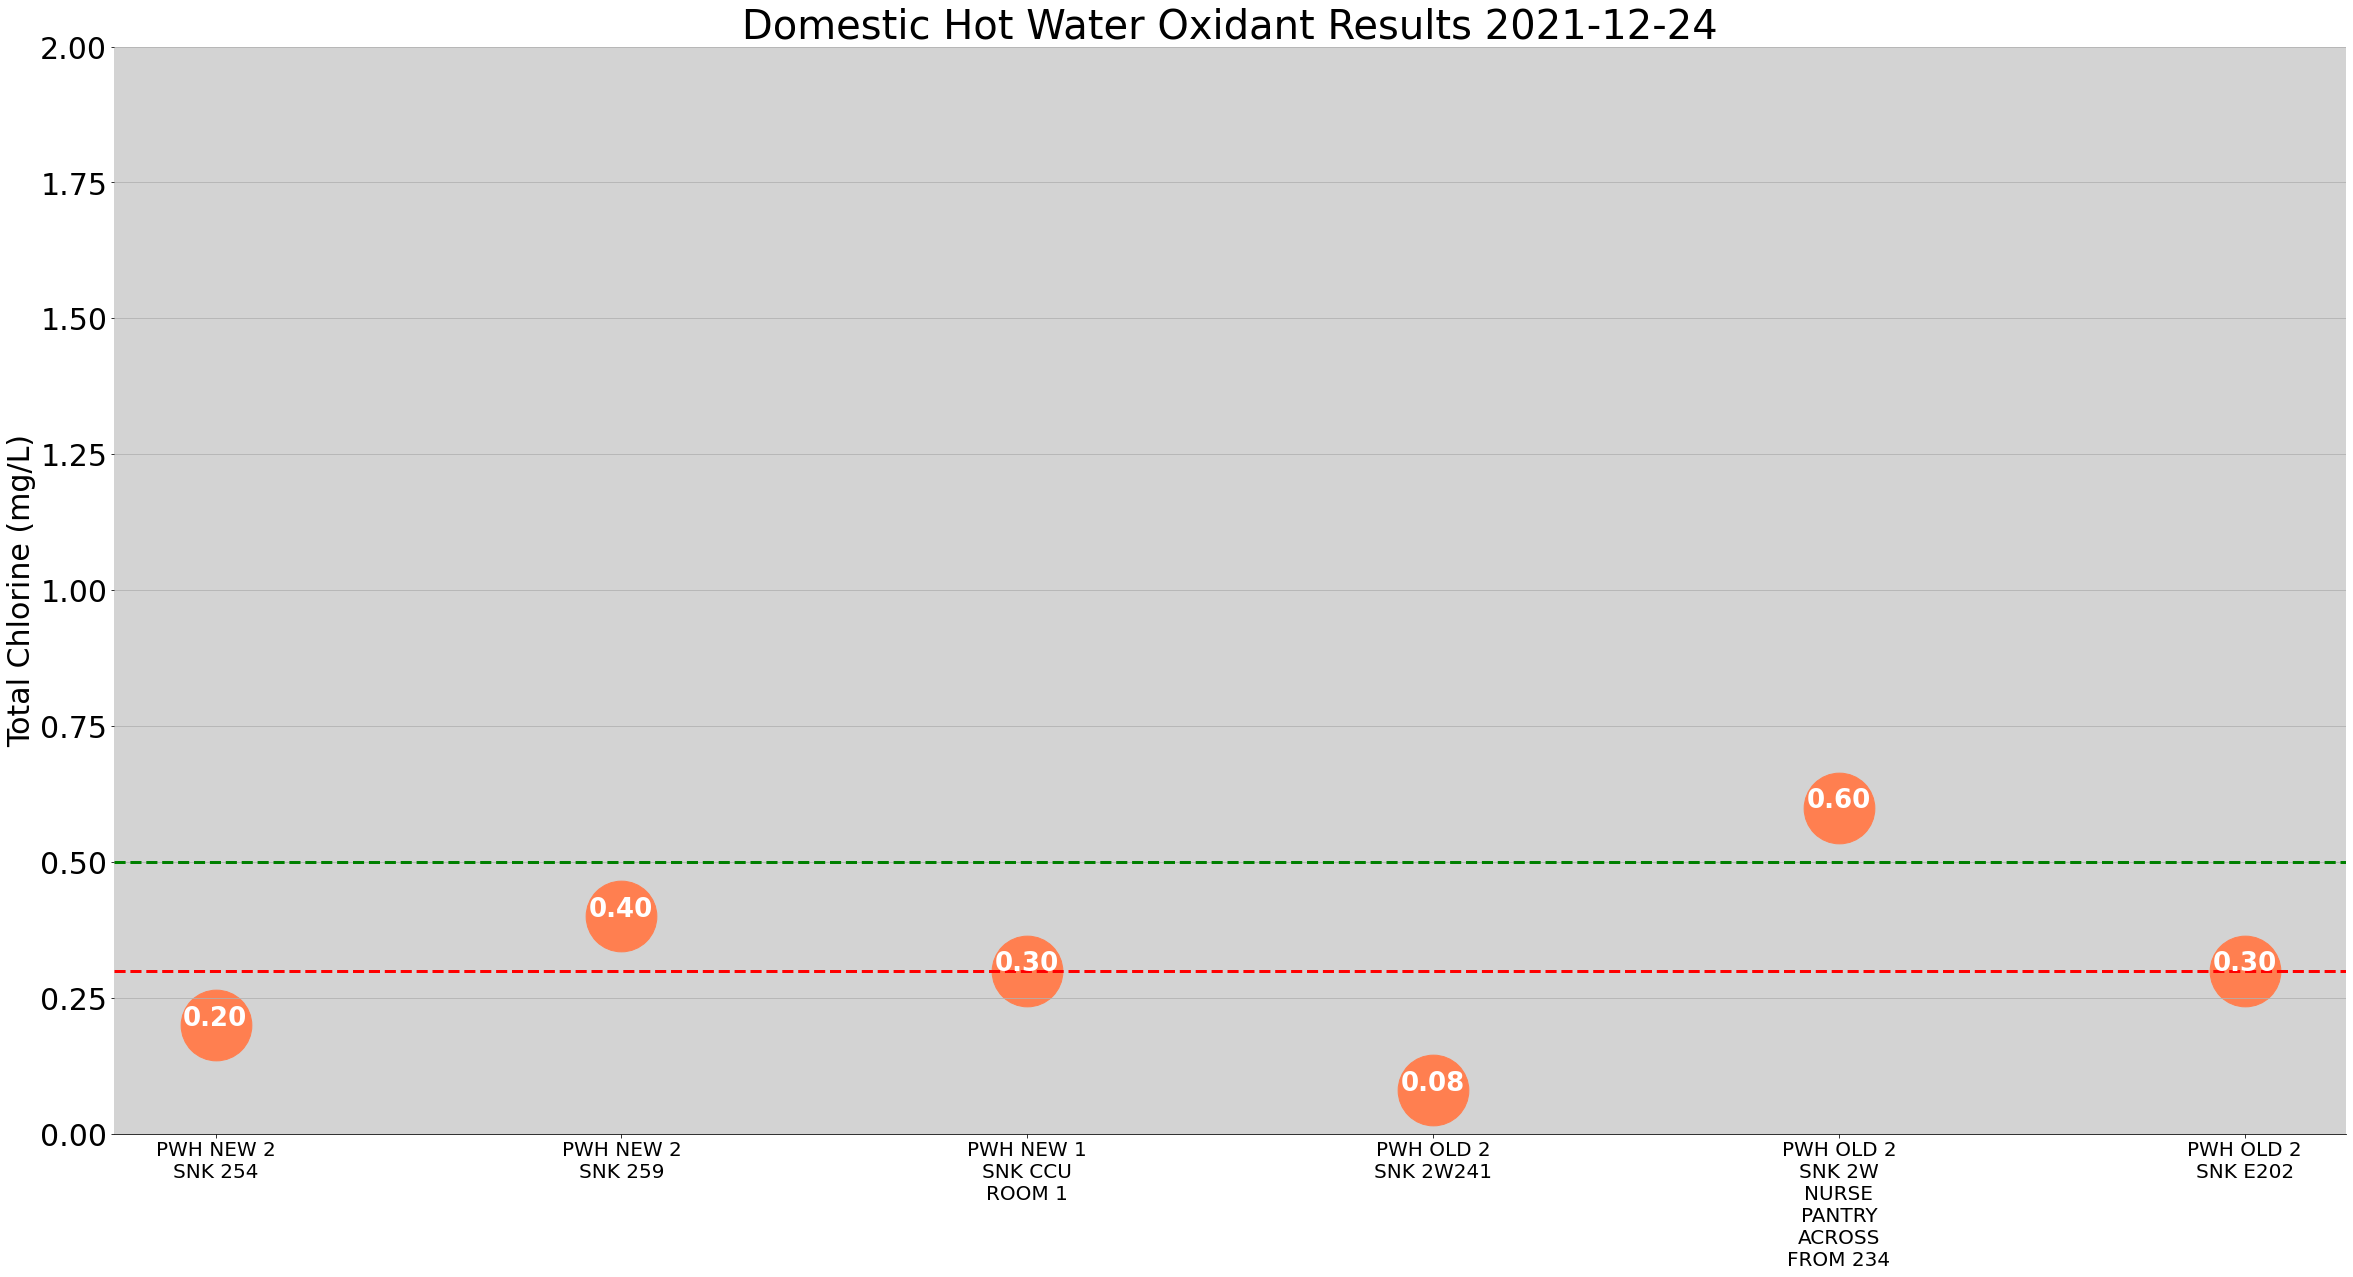

In [363]:
# Hot Oxidant Graph Generator

dataframe_to_use_1 = source_dict['PWH']
figure_size = (40,20)
y_min = 0
y_max = 2
y_high_risk = 0.3
y_low_risk = 0.5

lp_df_1 = dataframe_to_use_1[dataframe_to_use_1['Lp_Positive'] == 'YES']

###################

fig,ax = plt.subplots(1,1,figsize=figure_size)

xlabels = ['\n'.join(wrap(l, 10)) for l in list(dataframe_to_use_1.full_sample_name)]
xlabels_lp = ['\n'.join(wrap(l, 10)) for l in list(lp_df_1.full_sample_name)]

ax.scatter(xlabels,dataframe_to_use_1['TRO'],s=5000,color='coral')
ax.scatter(xlabels_lp,lp_df_1['TRO'],s=5000,facecolors='None', edgecolor='red',linewidths=10)

ax.set_ylabel('Total Chlorine (mg/L)')
ax.set_title(f'Domestic Hot Water Oxidant Results {sample_date}')
ax.set_ylim((y_min,y_max))
ax.axhline(y=y_high_risk,color='r',linestyle='--',linewidth=3)
ax.axhline(y=y_low_risk,color='green',linestyle='--',linewidth=3)
ax.set_facecolor('lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y')

plot_text = list(dataframe_to_use_1.TRO)
plot_text = [str(x) if len(str(x)) > 3 else str(x) + '0' for x in plot_text]

spacing_dict = {1:0, 2:-0.01, 3:-0.02, 6: -0.08}
spacing = list(np.arange(start=spacing_dict[len(dataframe_to_use_1.index)],
                         stop=len(dataframe_to_use_1.index),
                         step=1))

for i, txt in enumerate(plot_text):
    ax.annotate(txt, (spacing[i],list(dataframe_to_use_1['TRO'])[i]),
                size=26,color='white',weight='bold')

plt.savefig('images/DHW_oxidant.png')

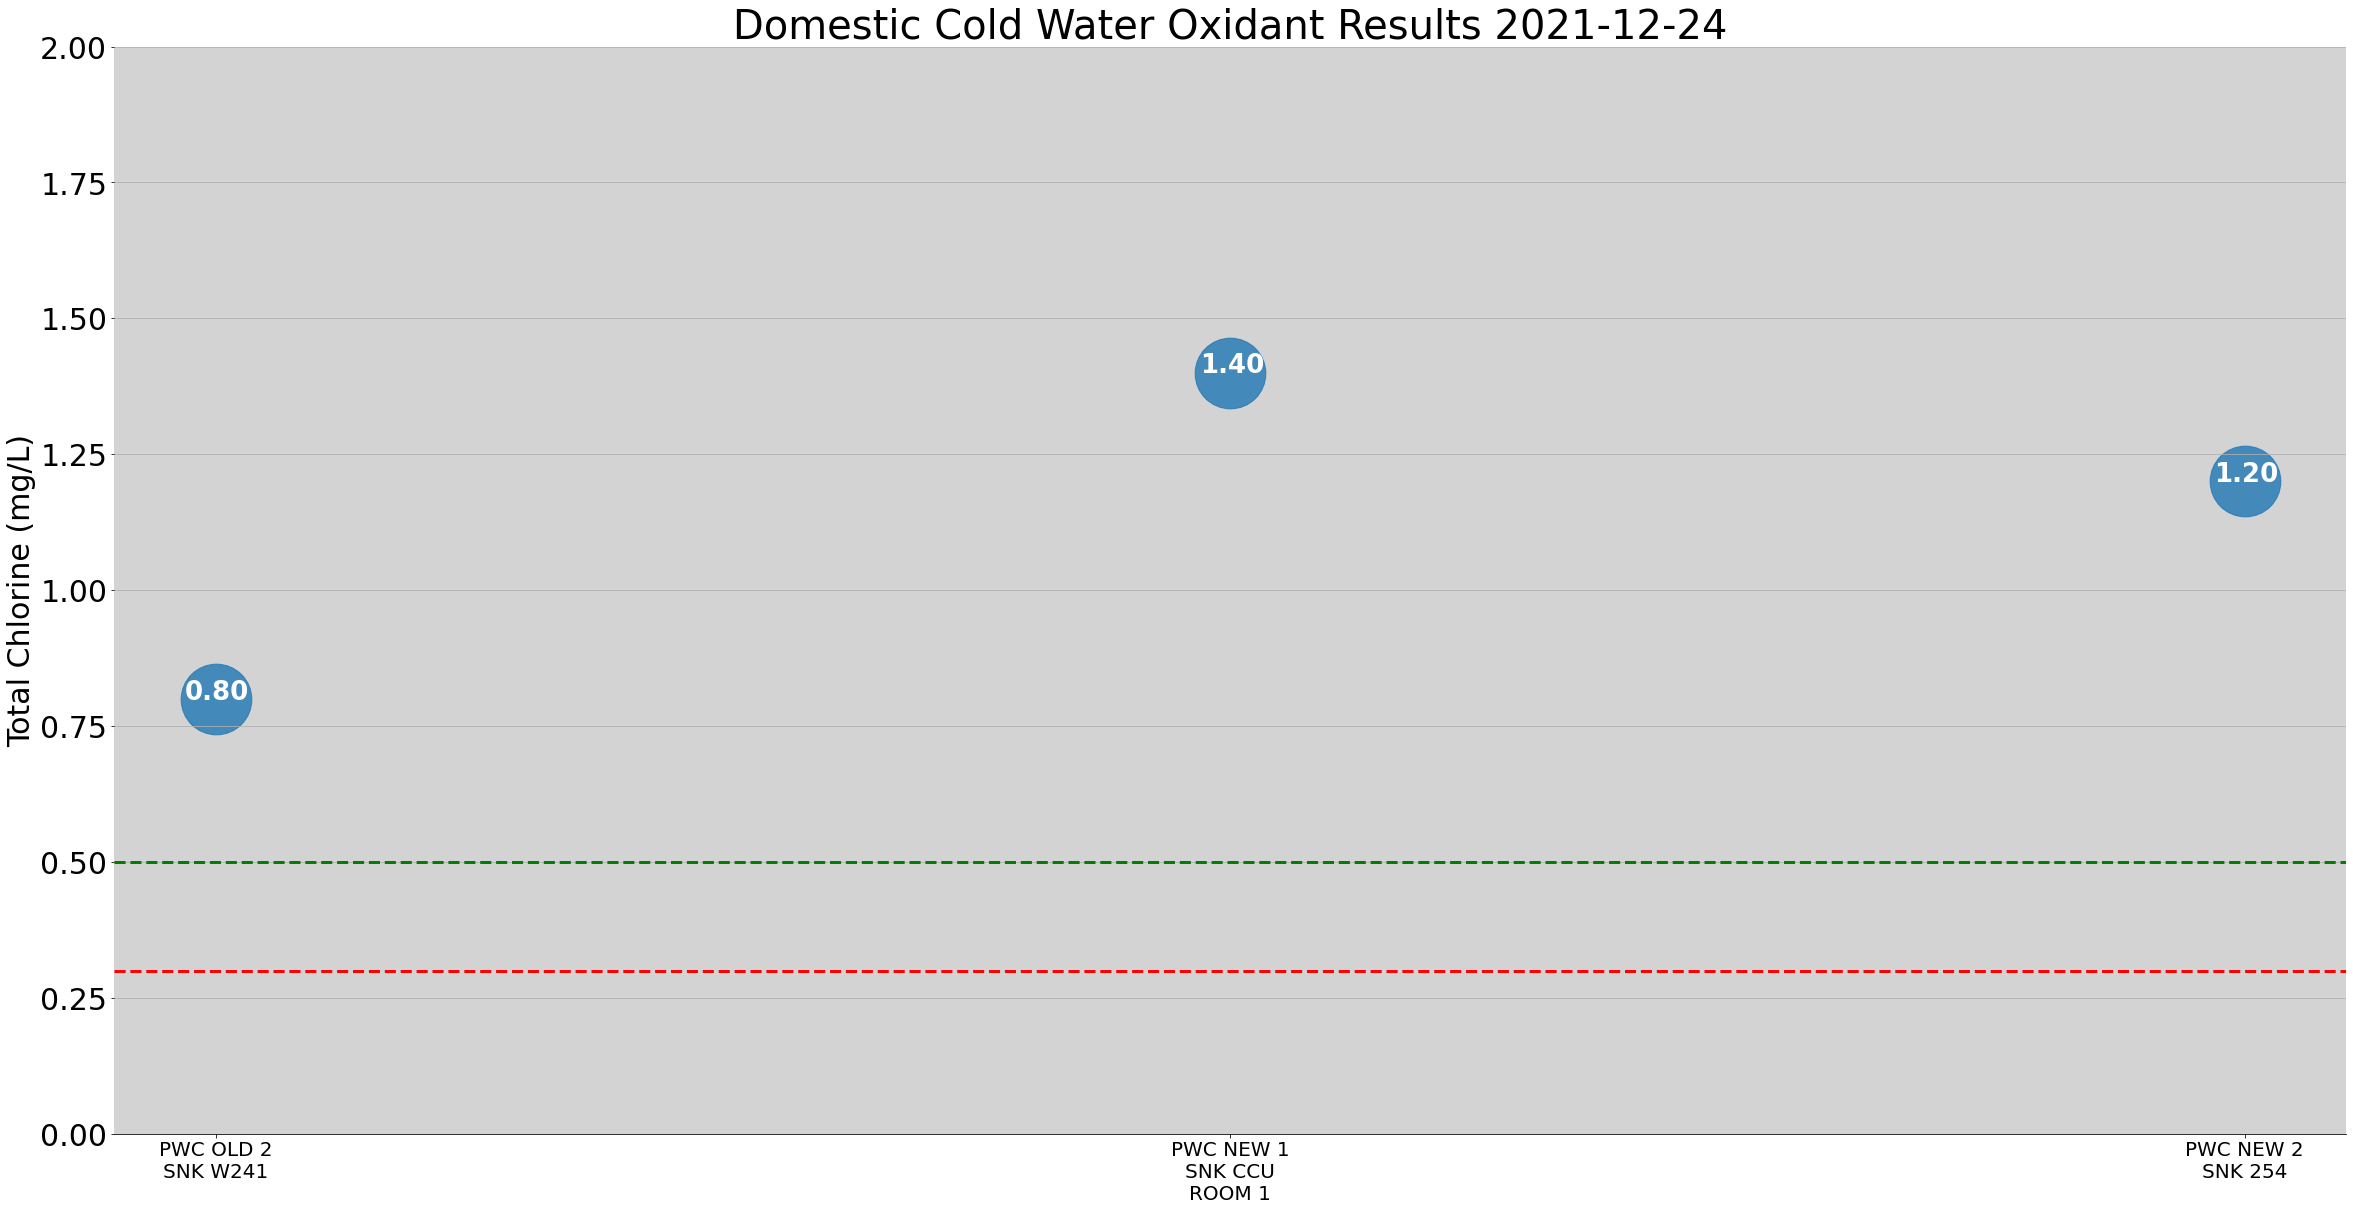

In [364]:
# Cold Oxidant Graph Generator

dataframe_to_use_1 = source_dict['PWC']
figure_size = (40,20)
y_min = 0
y_max = 2
y_high_risk = 0.3
y_low_risk = 0.5

lp_df_1 = dataframe_to_use_1[dataframe_to_use_1['Lp_Positive'] == 'YES']

###################

fig,ax = plt.subplots(1,1,figsize=figure_size)

xlabels = ['\n'.join(wrap(l, 10)) for l in list(dataframe_to_use_1.full_sample_name)]
xlabels_lp = ['\n'.join(wrap(l, 10)) for l in list(lp_df_1.full_sample_name)]

ax.scatter(xlabels,dataframe_to_use_1['TRO'],s=5000,alpha=0.8)
ax.scatter(xlabels_lp,lp_df_1['TRO'],s=5000,facecolors='None', edgecolor='red',linewidths=10)

ax.set_ylabel('Total Chlorine (mg/L)')
ax.set_title(f'Domestic Cold Water Oxidant Results {sample_date}')
ax.set_ylim((y_min,y_max))
ax.axhline(y=y_high_risk,color='r',linestyle='--',linewidth=3)
ax.axhline(y=y_low_risk,color='green',linestyle='--',linewidth=3)
ax.set_facecolor('lightgrey')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y')


plot_text = list(dataframe_to_use_1.TRO)
plot_text = [str(x) if len(str(x)) > 3 else str(x) + '0' for x in plot_text]

spacing_dict = {1:0, 2:-0.01, 3:-0.03, 6: -0.08}
spacing = list(np.arange(start=spacing_dict[len(dataframe_to_use_1.index)],
                         stop=len(dataframe_to_use_1.index),
                         step=1))

for i, txt in enumerate(plot_text):
    ax.annotate(txt, (spacing[i],list(dataframe_to_use_1['TRO'])[i]),
                size=26,color='white',weight='bold')

plt.savefig('images/DCW_oxidant.png')

## Legionella Trends and Modeling

In [365]:
def yes_to_one(x):
    if x == 'YES':
        return 1
    elif x == 'NO':
        return 0

hist_df['Lp_Positive'] = hist_df['Lp_Positive'].map(yes_to_one)

In [366]:
small_source_dict = {}
for source_type in list(hist_df.Source.value_counts().index):
    small_source_dict[source_type] = []

for i in range(len(hist_df)):
    for source_type in list(hist_df.Source.value_counts().index):
        if (hist_df.iloc[i][2] == source_type) & (hist_df.iloc[i][12] == 1):
            small_source_dict[source_type].append(1)
        else:
            small_source_dict[source_type].append(0)
    
lp_hist_df = pd.concat((hist_df,pd.DataFrame(small_source_dict)),axis=1).filter((['Date', 'Area'] + list(hist_df.Source.value_counts().index)))

lp_area_dict = {}
lp_area_list = []
lp_area_uniques = list(lp_hist_df.Area.value_counts().index)
for unique_group in lp_area_uniques:
    lp_area_dict[f'{unique_group}'] = lp_hist_df[lp_hist_df['Area'] == unique_group]
    lp_area_dict[f'{unique_group}'] = lp_area_dict[f'{unique_group}'].groupby('Date').sum()
    lp_area_list.append(lp_area_dict[f'{unique_group}'])


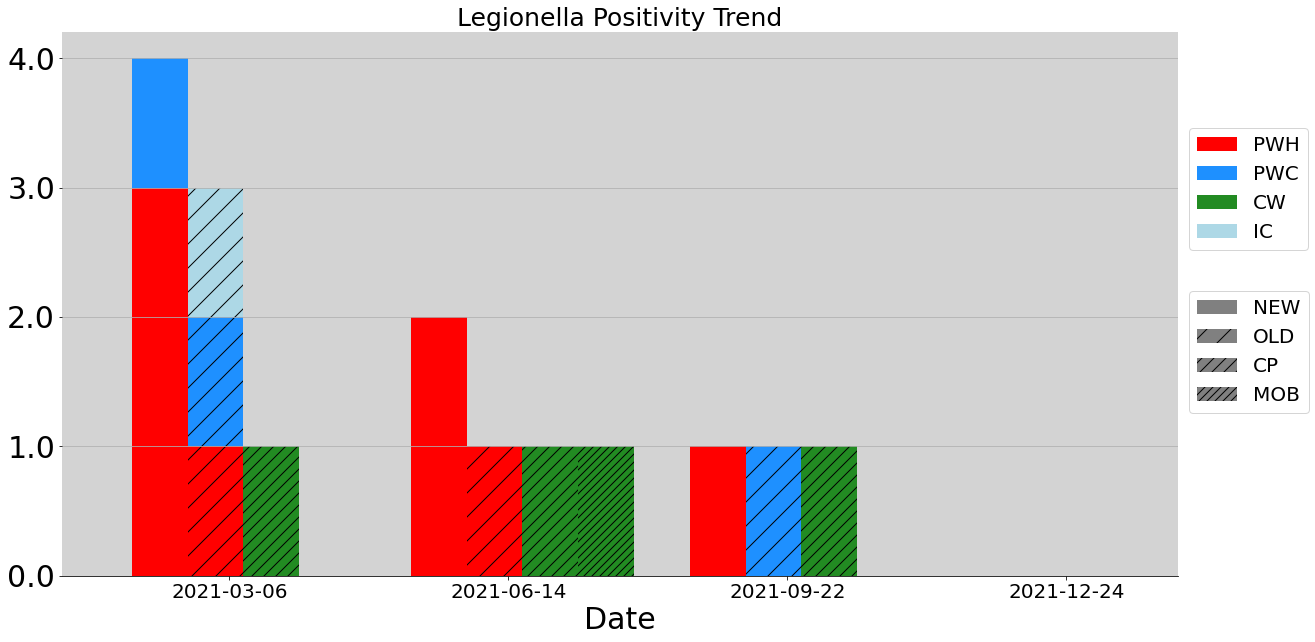

In [374]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      color=['red','dodgerblue','forestgreen','lightblue'],
                      figsize= (20,10),
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title,size=25)
    axe.set_facecolor('lightgrey')
    axe.spines['top'].set_visible(False)
    axe.spines['right'].set_visible(False)
    axe.spines['left'].set_visible(False)
    axe.grid(axis='y')
    start, end = axe.get_ylim()
    axe.yaxis.set_ticks(np.arange(start, end, 1))
    axe.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.6])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.3]) 
    axe.add_artist(l1)
    return axe

# Then, just call :
plot_clustered_stacked(lp_area_list,list(hist_df.Area.value_counts().index),title= "Legionella Positivity Trend")
plt.savefig('images/lp_trend.png')